<a href="https://colab.research.google.com/github/CIA-Oceanix/DLCourse_MOi_2022/blob/main/notebooks/notebook_PytorchLightning_MNIST_AutoEncoder_with_correction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Deep Auto-Encoders using pytorch


---



## 1- Data management <a class="anchor" id="section_1"></a>

Start with these lines of code to automatically download the Fashion-MNIST dataset.

In [10]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets
import torchvision.transforms as transforms

transform = transforms.Compose([
     transforms.ToTensor(),
 ])


#train_data = datasets.FashionMNIST(root = 'data', train = True, download = True, transform = transform)
#test_data = datasets.FashionMNIST(root = 'data', train = False, download = True, transform = transform)

train_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)

In [11]:
num_train, num_test = len(train_data), len(test_data) # TO DO
print('A =', num_train) # TO DO
print('B =', num_test) # TO DO
print('C =', train_data.data.shape[1]) # TO DO
print('D =', len(train_data.classes)) # TO DO

A = 60000
B = 10000
C = 28
D = 10


As indicated below, each Fashion-MNIST sample is assigned to one of the following classes: 0: T-shirt/top, 1: Trouser, 2: Pullover, 3: Dress, 4: Coat, 5: Sandal, 6: Shirt, 7: Sneaker, 8: Bag, 9: Ankle boot.

In [12]:
class_names = train_data.classes
print(class_names)

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


In [13]:
import torch
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

batch_size = 20
valid_size = 0.2

train_size = 0.2
indices = np.random.permutation(len(train_data))[:int(train_size*len(train_data))]
train_data_subset = torch.utils.data.Subset(train_data,indices )

def create_data_loaders(batch_size, valid_size, train_data, test_data): # FUNCTION TO BE COMPLETED

  total_train = len(train_data)
  num_val = int(total_train * valid_size)
  num_train = total_train - num_val

  tr_data, val_data = torch.utils.data.random_split(train_data, [num_train, num_val])
  train_loader = torch.utils.data.DataLoader(tr_data, batch_size = batch_size)
  valid_loader = torch.utils.data.DataLoader(val_data, batch_size = batch_size)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size)

  return train_loader, valid_loader, test_loader

In [14]:
train_loader, valid_loader, test_loader = create_data_loaders(batch_size, valid_size, train_data_subset, test_data) # TO DO

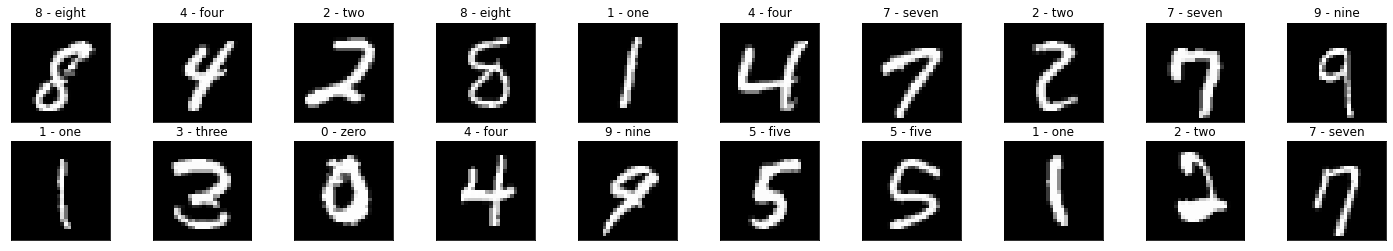

In [15]:
# CELL TO BE COMPLETED
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

data_iter = iter(train_loader)
images, labels = data_iter.next()
images = images.numpy()
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(class_names[labels[idx].item()]))

### **Test and comparison to PCA**

In [16]:
dim_pca = 4

from sklearn.decomposition import PCA

#mse,test_recon = test_epoch(encoder,decoder,device,test_loader,loss_fn)
#mse

# learn PCA
X = train_data.data.reshape((train_data.data.shape[0],28*28))
pca = PCA(n_components=dim_pca)
pca.fit(X)

PCA(n_components=4)

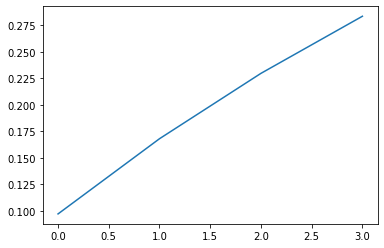

In [17]:
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))


In [18]:
# apply PCA to test data
X = test_data.data.numpy()
X = X.reshape((test_data.data.shape[0],28*28))
out_pca = pca.inverse_transform( pca.transform(X) )
out_pca = out_pca.reshape((test_data.data.shape[0],28,28))
mse_pca = np.mean( (test_data.data.numpy() - out_pca) **2 )

var_exp_test = 1. - mse_pca / np.var( X[:] )
print('.... (PCA) Explained variance for test dataset = %.3f' %(100 * var_exp_test ))

.... (PCA) Explained variance for test dataset = 50.307


## 2-**MLP Auto-encoder architecture** 

In [ ]:
class Encoder(nn.Module): 
    def __init__(self, encoded_space_dim=10,fc2_input_dim=10):
        super(Encoder,self).__init__()
        hidden_1, hidden_2 = fc2_input_dim , encoded_space_dim
        self.fc1 = nn.Linear(28*28, hidden_1)
        self.fc2 = nn.Linear(hidden_1,hidden_2)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self,x): # FUNCTION TO BE COMPLETED
        x = x.view(-1,28*28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        return x

class Decoder(nn.Module): 
    def __init__(self, encoded_space_dim=10,fc2_input_dim=10): # FUNCTION TO BE COMPLETED
        super(Decoder,self).__init__()
        hidden_1, hidden_2 = encoded_space_dim , fc2_input_dim
        self.fc1 = nn.Linear( hidden_1, fc2_input_dim)
        self.fc2 = nn.Linear(fc2_input_dim,28*28)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self,x): # FUNCTION TO BE COMPLETED
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = x.view(-1,1,28,28)
        return x


## 2- **Convolutional Auto-Encoder architecture**

In [19]:
#import torch.nn as nn
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [20]:
pip install pytorch_lightning==1.6.5 -q

     |████████████████████████████████| 585 kB 31.8 MB/s 
     |████████████████████████████████| 419 kB 72.4 MB/s 


In [21]:
import pytorch_lightning as pl
import torch.nn as nn
import torch.nn.functional as F

class LitAE(pl.LightningModule): # TODO 1
    def __init__(self):
        super().__init__()

        self.dim_ae = 4
        self.encoder = Encoder(encoded_space_dim=self.dim_ae,fc2_input_dim=128)
        self.decoder = Decoder(encoded_space_dim=self.dim_ae,fc2_input_dim=128)

        if True:  ## TODO 1
          self.criterion = torch.nn.MSELoss()
        
        if True:  ## TODO 5
          self.test_data = None
        
    def forward(self,x): 
        out = self.encoder(x)
        out = self.decoder(out)

        return out
    
    def training_step(self, batch, batch_idx): ## TODO 1
        data, label = batch
        output = self(data)
        loss = self.criterion(output, data)
        self.log('train_loss', loss) ## TODO 3
        return loss
    
    def validation_step(self, batch, batch_idx): ## TODO 1
        data, label = batch
        output = self(data)
        loss = self.criterion(output, data)
        self.log('val_loss', loss) ## TODO 3
        return loss
  
    def configure_optimizers(self): ## TODO 1
        #return torch.optim.SGD(self.parameters(),lr = 0.001, weight_decay=1e-05) 
        return torch.optim.Adam(self.parameters(),lr = 0.001, weight_decay=1e-05) 

    def test_step(self, batch, batch_idx): ## TODO 5
        data, label = batch
        output = self(data)
        latent = self.encoder(data)

        loss = self.criterion(output, data)
        self.log('test_loss', loss)

        preds = output.cpu()
        return data.cpu(), preds, latent.cpu()

    def test_epoch_end(self, test_step_outputs): ## TODO 5
        list_of_data, list_of_preds,list_of_latent = zip(*test_step_outputs)
        data, preds,latents = torch.cat(list_of_data),  torch.cat(list_of_preds),  torch.cat(list_of_latent)
        
        self.test_data = 255 * data.numpy(), 255 * preds.numpy(), latents.numpy()

In [24]:
model = LitAE()

model_checkpoint = pl.callbacks.ModelCheckpoint(monitor='val_loss') # TODO 4
logger = pl.loggers.CSVLogger('logs', name='mlp_mnist') 
trainer = pl.Trainer(
    gpus=1, 
    max_epochs=10,
    callbacks=[model_checkpoint], # TODO 4
    logger=logger
  )



INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params
--------------------------------------
0 | encoder   | Encoder | 43.4 K
1 | decoder   | Decoder | 43.7 K
2 | criterion | MSELoss | 0     
--------------------------------------
87.1 K    Trainable params
0         Non-trainable params
87.1 K    Total params
0.348     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Logs stored at logs/mlp_mnist/version_1/metrics.csv


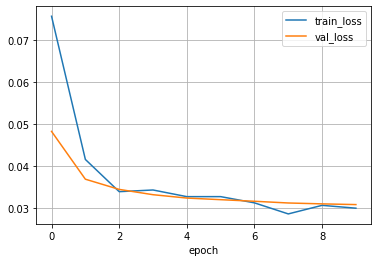

In [25]:
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=valid_loader)
print(f"Logs stored at {logger.log_dir}/metrics.csv")


## Plot metrics
(
    pd.read_csv(f'{logger.log_dir}/metrics.csv') .groupby('epoch').mean()
    [['train_loss', 'val_loss']].plot(grid=True)
)

In [27]:
print(f"""
    Best model saved at {model_checkpoint.best_model_path}
    With validation loss {model_checkpoint.best_model_score}
""")

# Loading best model
best_model = LitAE.load_from_checkpoint(model_checkpoint.best_model_path)


    Best model saved at logs/mlp_mnist/version_1/checkpoints/epoch=9-step=4800.ckpt
    With validation loss 0.030734630301594734



In [28]:
### Explained variance for the convolutional auto-encoder
trainer.test(best_model, dataloaders=test_loader)

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.030658548697829247
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.030658548697829247}]

In [29]:
### Explained variance for the convolutional auto-encoder
x_in,x_ae, x_latent = best_model.test_data

# denormalization
#out_ae = 255 * out_ae

mse_convae = np.mean( ( x_ae - x_in)**2 )
mse_pca = np.mean( (out_pca - test_data.data.numpy())**2 )

var_exp_ae = 1. - mse_convae / np.var( x_in )
var_exp_pca = 1. - mse_pca / np.var( x_in )

print('....... Explained variance for test dataset ' )
print('... PCA (%d) = %.3f'%(dim_pca,100. * var_exp_pca))
print('... AE (%d) = %.3f'%(model.dim_ae,100. * var_exp_ae))


....... Explained variance for test dataset 
... PCA (4) = 50.307
... AE (4) = 68.196


In [30]:
def plot_ae_outputs(litAE,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_data.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_data[t_idx[i]][0].unsqueeze(0).to(device)

      
      litAE.encoder.eval()
      litAE.decoder.eval()
      with torch.no_grad():
         rec_img  = litAE.decoder(litAE.encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

Selected device: cuda


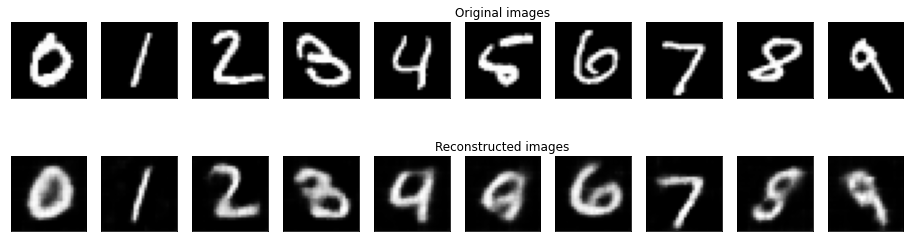

In [32]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')
best_model.to(device)

plot_ae_outputs(best_model,n=10)

# Generation of random images from latent codes

Selected device: cuda
tensor([ 0.3430,  0.1789, -0.1012,  0.1368], device='cuda:0')
tensor([1.3529, 1.0231, 1.1558, 1.0646], device='cuda:0')


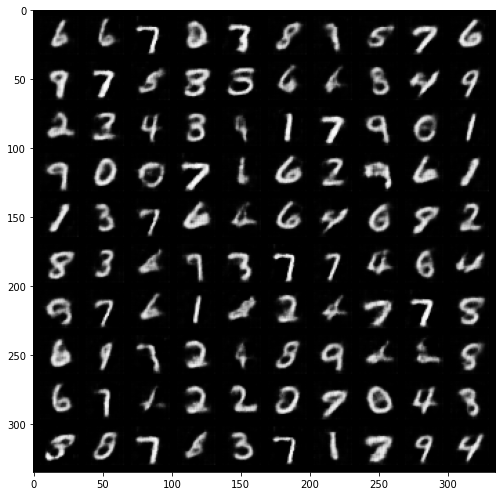

In [33]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

best_model.to(device)
best_model.encoder.eval()
best_model.decoder.eval()

with torch.no_grad():
    # calculate mean and std of latent code, generated takining in test images as inputs 
    x_in,x_ae, x_latent = best_model.test_data

    x_latent = torch.Tensor(x_latent).to(device)
    mean = x_latent.mean(dim=0)
    print(mean)
    std = (x_latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, model.dim_ae).to(device)
    latent = latent * std + mean

    # reconstruct images from the random latent vectors
    latent = latent.to(device)
    img_recon = best_model.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
    plt.show()